In [ ]:
# =============================================================================
# CELL 1: INSTALLATION & SETUP
# =============================================================================
print("=" * 80)
print("🚀 INSTALLING PYSPARK")
print("=" * 80)

!pip install pyspark==3.4.1 -q
!pip install matplotlib seaborn -q

print("✅ Installation complete!")


🚀 INSTALLING PYSPARK
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 15.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.1 requires pyspark[connect]~=4.0.0, but you have pyspark 3.4.1 which is incompatible.
✅ Installation complete!


In [ ]:
# =============================================================================
# CELL 2: IMPORTS
# =============================================================================
print("\n" + "=" * 80)
print("📦 IMPORTING LIBRARIES")
print("=" * 80)

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, when, sum as spark_sum, avg, stddev,
    min as spark_min, max as spark_max, round as spark_round,
    countDistinct, desc, asc, year, month, dayofmonth,
    concat, lit, upper, lower, trim, regexp_replace,
    datediff, current_date, row_number, rank, dense_rank,
    lag, lead, first, last, collect_list
)
from pyspark.sql.window import Window
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")


📦 IMPORTING LIBRARIES
✅ All libraries imported successfully!


In [ ]:
# =============================================================================
# CELL 3: CREATE SPARK SESSION
# =============================================================================
print("\n" + "=" * 80)
print("⚡ CREATING SPARK SESSION")
print("=" * 80)

spark = SparkSession.builder \
    .appName("E-commerce_Data_Processing") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.sql.adaptive.enabled", "true") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print(f"✅ Spark Version: {spark.version}")
print(f"✅ Master: {spark.sparkContext.master}")
print("=" * 80)


⚡ CREATING SPARK SESSION
✅ Spark Version: 3.4.1
✅ Master: local[*]


In [ ]:
# =============================================================================
# CELL 4: MOUNT GOOGLE DRIVE & LOAD DATA
# =============================================================================
print("\n" + "=" * 80)
print("☁️ MOUNTING GOOGLE DRIVE & LOADING DATA")
print("=" * 80)

from google.colab import drive
drive.mount('/content/drive')

# Path to cleaned data (without features)
data_path = "/content/drive/MyDrive/BigDataProject/cleaned_without_features/cleaned_without_features.csv"

print(f"📁 Loading data from: {data_path}")

# Load the cleaned data
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv(data_path)

# Cache for better performance
df.cache()

print(f"✅ Data loaded successfully!")
print(f"📊 Rows: {df.count():,}")
print(f"📊 Columns: {len(df.columns)}")


☁️ MOUNTING GOOGLE DRIVE & LOADING DATA
Mounted at /content/drive
📁 Loading data from: /content/drive/MyDrive/BigDataProject/cleaned_without_features/cleaned_without_features.csv
✅ Data loaded successfully!
📊 Rows: 180,519
📊 Columns: 60


In [ ]:
# =============================================================================
# CELL 5: DATA OVERVIEW
# =============================================================================
print("\n" + "=" * 80)
print("📋 DATA OVERVIEW")
print("=" * 80)

print("\n🔍 Schema:")
df.printSchema()

print("\n👀 Sample Data (first 5 rows):")
df.show(5, truncate=True)

print("\n📊 Key Statistics:")
key_columns = ['Sales', 'Order Item Quantity', 'Days for shipping (real)',
               'Order Item Discount', 'Order Profit Per Order']
existing_cols = [c for c in key_columns if c in df.columns]
if existing_cols:
    df.select(existing_cols).describe().show()


📋 DATA OVERVIEW

🔍 Schema:
root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Market: string (nullable = true)
 |-- Order City: string (nullable = 

In [ ]:
# =============================================================================
# CELL 6: CREATE SQL TEMPORARY VIEW
# =============================================================================
print("\n" + "=" * 80)
print("🗄️ CREATING SQL TEMPORARY VIEW")
print("=" * 80)

# Register DataFrame as a SQL table
df.createOrReplaceTempView("orders")
print("✅ Temporary view 'orders' created")
print("💡 You can now query the data using SQL!")

# Verify the view
print("\n📊 Available tables:")
spark.sql("SHOW TABLES").show()


🗄️ CREATING SQL TEMPORARY VIEW
✅ Temporary view 'orders' created
💡 You can now query the data using SQL!

📊 Available tables:
+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |   orders|       true|
+---------+---------+-----------+




📊 PROCESSING #1: SALES ANALYSIS BY CATEGORY
Method: DataFrame API (Core Transformations)
--------------------------------------------------------------------------------

📈 Sales Performance by Category:
+--------------------+------------+------------------+------------------+------------------+----------------+-------------+
|Category Name       |total_orders|total_sales       |avg_order_value   |total_profit      |unique_customers|profit_margin|
+--------------------+------------+------------------+------------------+------------------+----------------+-------------+
|Fishing             |17325       |6929653.690574673 |399.9800109999811 |756220.7671894991 |8759            |10.91        |
|Cleats              |24551       |4431942.783185066 |180.5198477937789 |494636.91979056265|10049           |11.16        |
|Camping & Hiking    |13729       |4118425.571019035 |299.98001100000255|427455.56810572953|7788            |10.38        |
|Cardio Equipment    |12487       |3694843.19663007

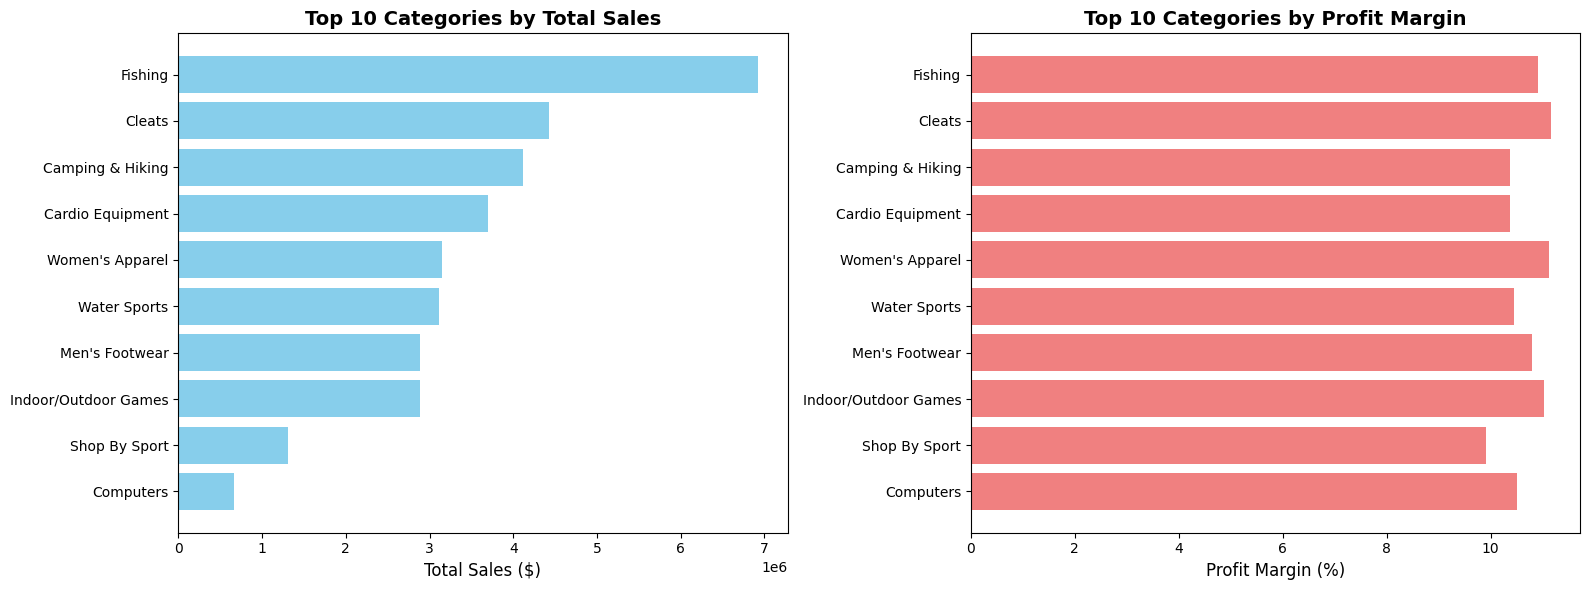


✅ Results saved to Google Drive!


In [ ]:
# =============================================================================
# CELL 7: PROCESSING #1 - SALES BY CATEGORY (DataFrame API)
# =============================================================================
print("\n" + "=" * 80)
print("📊 PROCESSING #1: SALES ANALYSIS BY CATEGORY")
print("=" * 80)
print("Method: DataFrame API (Core Transformations)")
print("-" * 80)

# Using DataFrame API
sales_by_category_df = df.groupBy('Category Name') \
    .agg(
        count('*').alias('total_orders'),
        spark_sum('Sales').alias('total_sales'),
        avg('Sales').alias('avg_order_value'),
        spark_sum('Order Profit Per Order').alias('total_profit'),
        countDistinct('Customer Id').alias('unique_customers')
    ) \
    .withColumn('profit_margin',
                spark_round(col('total_profit') / col('total_sales') * 100, 2)) \
    .orderBy(desc('total_sales'))

print("\n📈 Sales Performance by Category:")
sales_by_category_df.show(20, truncate=False)

# Visualization
print("\n📊 Visualizing Top 10 Categories by Sales...")
pandas_df = sales_by_category_df.limit(10).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart - Total Sales
axes[0].barh(pandas_df['Category Name'], pandas_df['total_sales'], color='skyblue')
axes[0].set_xlabel('Total Sales ($)', fontsize=12)
axes[0].set_title('Top 10 Categories by Total Sales', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Bar chart - Profit Margin
axes[1].barh(pandas_df['Category Name'], pandas_df['profit_margin'], color='lightcoral')
axes[1].set_xlabel('Profit Margin (%)', fontsize=12)
axes[1].set_title('Top 10 Categories by Profit Margin', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Save results
sales_by_category_df.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .csv("/content/drive/MyDrive/BigDataProject/processing_results/01_sales_by_category")
print("\n✅ Results saved to Google Drive!")

In [ ]:
# =============================================================================
# CELL 8: PROCESSING #1 - SALES BY CATEGORY (Spark SQL)
# =============================================================================
print("\n" + "=" * 80)
print("📊 PROCESSING #1: SALES ANALYSIS BY CATEGORY")
print("=" * 80)
print("Method: Spark SQL")
print("-" * 80)

# Using Spark SQL - Same analysis
sales_by_category_sql = spark.sql("""
    SELECT
        `Category Name`,
        COUNT(*) as total_orders,
        SUM(Sales) as total_sales,
        ROUND(AVG(Sales), 2) as avg_order_value,
        SUM(`Order Profit Per Order`) as total_profit,
        COUNT(DISTINCT `Customer Id`) as unique_customers,
        ROUND((SUM(`Order Profit Per Order`) / SUM(Sales)) * 100, 2) as profit_margin
    FROM orders
    GROUP BY `Category Name`
    ORDER BY total_sales DESC
""")

print("\n📈 Sales Performance by Category (SQL Results):")
sales_by_category_sql.show(20, truncate=False)

print("\n✅ Both methods produce identical results!")
print("💡 DataFrame API vs SQL: Choose what you're comfortable with!")



📊 PROCESSING #1: SALES ANALYSIS BY CATEGORY
Method: Spark SQL
--------------------------------------------------------------------------------

📈 Sales Performance by Category (SQL Results):
+--------------------+------------+------------------+---------------+------------------+----------------+-------------+
|Category Name       |total_orders|total_sales       |avg_order_value|total_profit      |unique_customers|profit_margin|
+--------------------+------------+------------------+---------------+------------------+----------------+-------------+
|Fishing             |17325       |6929653.690574673 |399.98         |756220.7671894991 |8759            |10.91        |
|Cleats              |24551       |4431942.783185066 |180.52         |494636.91979056265|10049           |11.16        |
|Camping & Hiking    |13729       |4118425.571019035 |299.98         |427455.56810572953|7788            |10.38        |
|Cardio Equipment    |12487       |3694843.1966300765|295.9          |383011.09848

In [ ]:
# =============================================================================
# CELL 10: PROCESSING #2 - CUSTOMER SEGMENTATION (Spark SQL)
# =============================================================================
print("\n" + "=" * 80)
print("👥 PROCESSING #2: CUSTOMER SEGMENTATION ANALYSIS")
print("=" * 80)
print("Method: Spark SQL")
print("-" * 80)

customer_analysis_sql = spark.sql("""
    SELECT
        `Customer Segment`,
        COUNT(DISTINCT `Customer Id`) as customer_count,
        ROUND(AVG(total_lifetime_value), 2) as avg_lifetime_value,
        ROUND(AVG(total_orders), 2) as avg_orders,
        SUM(total_lifetime_value) as total_segment_revenue
    FROM (
        SELECT
            `Customer Id`,
            `Customer Segment`,
            COUNT(`Order Id`) as total_orders,
            SUM(Sales) as total_lifetime_value
        FROM orders
        GROUP BY `Customer Id`, `Customer Segment`
    )
    GROUP BY `Customer Segment`
    ORDER BY total_segment_revenue DESC
""")

print("\n📊 Customer Segment Analysis (SQL Results):")
customer_analysis_sql.show(truncate=False)


👥 PROCESSING #2: CUSTOMER SEGMENTATION ANALYSIS
Method: Spark SQL
--------------------------------------------------------------------------------

📊 Customer Segment Analysis (SQL Results):
+----------------+--------------+------------------+----------+---------------------+
|Customer Segment|customer_count|avg_lifetime_value|avg_orders|total_segment_revenue|
+----------------+--------------+------------------+----------+---------------------+
|Consumer        |10695         |1785.49           |8.74      |1.9095790155173972E7 |
|Corporate       |6239          |1790.1            |8.78      |1.1168406842990562E7 |
|Home Office     |3718          |1753.78           |8.67      |6520538.015215686    |
+----------------+--------------+------------------+----------+---------------------+




🚚 PROCESSING #3: DELIVERY PERFORMANCE ANALYSIS
Method: DataFrame API (Core Transformations)
--------------------------------------------------------------------------------

📦 Delivery Performance by Shipping Mode and Status:
+--------------+-----------------+--------------+--------------+--------------+--------------+------------------------+------------------+
|Shipping Mode |Delivery Status  |shipment_count|avg_delay_days|max_delay_days|min_delay_days|avg_actual_shipping_days|total_sales       |
+--------------+-----------------+--------------+--------------+--------------+--------------+------------------------+------------------+
|First Class   |Late delivery    |26513         |1.0           |1             |1             |2.0                     |5408068.562869078 |
|First Class   |Shipping canceled|1301          |1.0           |1             |1             |2.0                     |266301.19533340173|
|Same Day      |Late delivery    |4454          |1.0           |1             

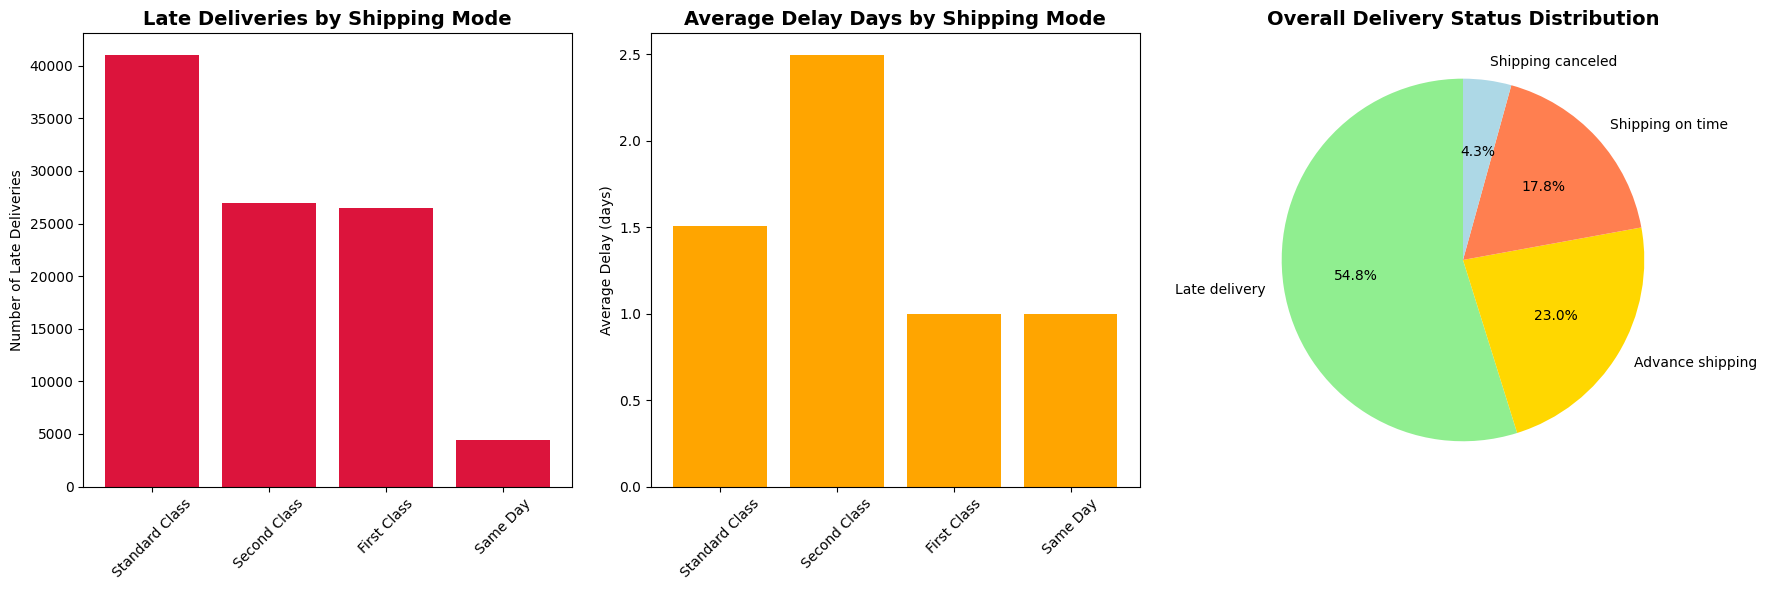


✅ Results saved to Google Drive!


In [ ]:
# =============================================================================
# CELL 11: PROCESSING #3 - DELIVERY PERFORMANCE (DataFrame API)
# =============================================================================
print("\n" + "=" * 80)
print("🚚 PROCESSING #3: DELIVERY PERFORMANCE ANALYSIS")
print("=" * 80)
print("Method: DataFrame API (Core Transformations)")
print("-" * 80)

# Calculate shipping delay
df_with_delay = df.withColumn(
    'shipping_delay',
    col('Days for shipping (real)') - col('Days for shipment (scheduled)')
)

# Delivery performance by shipping mode and status
delivery_performance_df = df_with_delay.groupBy('Shipping Mode', 'Delivery Status') \
    .agg(
        count('*').alias('shipment_count'),
        avg('shipping_delay').alias('avg_delay_days'),
        spark_max('shipping_delay').alias('max_delay_days'),
        spark_min('shipping_delay').alias('min_delay_days'),
        avg('Days for shipping (real)').alias('avg_actual_shipping_days'),
        spark_sum('Sales').alias('total_sales')
    ) \
    .withColumn('avg_delay_days', spark_round(col('avg_delay_days'), 2)) \
    .withColumn('avg_actual_shipping_days', spark_round(col('avg_actual_shipping_days'), 2)) \
    .orderBy('Shipping Mode', 'Delivery Status')

print("\n📦 Delivery Performance by Shipping Mode and Status:")
delivery_performance_df.show(50, truncate=False)

# Late delivery analysis by shipping mode
print("\n⚠️ Late Delivery Analysis by Shipping Mode:")
late_delivery_analysis = df_with_delay.filter(col('Delivery Status') == 'Late delivery') \
    .groupBy('Shipping Mode') \
    .agg(
        count('*').alias('late_deliveries'),
        avg('shipping_delay').alias('avg_delay_days'),
        countDistinct('Customer Id').alias('affected_customers'),
        spark_sum('Sales').alias('affected_sales')
    ) \
    .orderBy(desc('late_deliveries'))

late_delivery_analysis.show(truncate=False)

# Overall delivery performance summary
print("\n📊 Overall Delivery Performance Summary:")
overall_summary = df_with_delay.groupBy('Delivery Status') \
    .agg(
        count('*').alias('count'),
        spark_round((count('*') / df.count()) * 100, 2).alias('percentage')
    ) \
    .orderBy(desc('count'))

overall_summary.show(truncate=False)

# Visualization
print("\n📊 Visualizing Delivery Performance...")

# Prepare data for visualization
pandas_delivery = late_delivery_analysis.toPandas()
pandas_status = overall_summary.toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Late Deliveries by Shipping Mode
axes[0].bar(pandas_delivery['Shipping Mode'], pandas_delivery['late_deliveries'], color='crimson')
axes[0].set_title('Late Deliveries by Shipping Mode', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Late Deliveries')
axes[0].tick_params(axis='x', rotation=45)

# 2. Average Delay Days by Shipping Mode
axes[1].bar(pandas_delivery['Shipping Mode'], pandas_delivery['avg_delay_days'], color='orange')
axes[1].set_title('Average Delay Days by Shipping Mode', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average Delay (days)')
axes[1].tick_params(axis='x', rotation=45)

# 3. Overall Delivery Status Distribution
axes[2].pie(pandas_status['count'], labels=pandas_status['Delivery Status'],
            autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'gold', 'coral', 'lightblue'])
axes[2].set_title('Overall Delivery Status Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Save results
delivery_performance_df.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .csv("/content/drive/MyDrive/BigDataProject/processing_results/03_delivery_performance")
print("\n✅ Results saved to Google Drive!")

In [ ]:
# =============================================================================
# CELL 12: PROCESSING #3 - DELIVERY PERFORMANCE (Spark SQL)
# =============================================================================
print("\n" + "=" * 80)
print("🚚 PROCESSING #3: DELIVERY PERFORMANCE ANALYSIS")
print("=" * 80)
print("Method: Spark SQL")
print("-" * 80)

delivery_performance_sql = spark.sql("""
    SELECT
        `Shipping Mode`,
        `Delivery Status`,
        COUNT(*) as shipment_count,
        ROUND(AVG(`Days for shipping (real)` - `Days for shipment (scheduled)`), 2) as avg_delay_days,
        ROUND(AVG(`Days for shipping (real)`), 2) as avg_actual_shipping_days,
        SUM(Sales) as total_sales
    FROM orders
    GROUP BY `Shipping Mode`, `Delivery Status`
    ORDER BY `Shipping Mode`, `Delivery Status`
""")

print("\n📦 Delivery Performance (SQL Results):")
delivery_performance_sql.show(50, truncate=False)

# Late delivery analysis with SQL
late_delivery_sql = spark.sql("""
    SELECT
        `Shipping Mode`,
        COUNT(*) as late_deliveries,
        ROUND(AVG(`Days for shipping (real)` - `Days for shipment (scheduled)`), 2) as avg_delay_days,
        COUNT(DISTINCT `Customer Id`) as affected_customers,
        SUM(Sales) as affected_sales
    FROM orders
    WHERE `Delivery Status` = 'Late delivery'
    GROUP BY `Shipping Mode`
    ORDER BY late_deliveries DESC
""")

print("\n⚠️ Late Delivery Analysis (SQL Results):")
late_delivery_sql.show(truncate=False)





🚚 PROCESSING #3: DELIVERY PERFORMANCE ANALYSIS
Method: Spark SQL
--------------------------------------------------------------------------------

📦 Delivery Performance (SQL Results):
+--------------+-----------------+--------------+--------------+------------------------+------------------+
|Shipping Mode |Delivery Status  |shipment_count|avg_delay_days|avg_actual_shipping_days|total_sales       |
+--------------+-----------------+--------------+--------------+------------------------+------------------+
|First Class   |Late delivery    |26513         |1.0           |2.0                     |5408068.562869078 |
|First Class   |Shipping canceled|1301          |1.0           |2.0                     |266301.19533340173|
|Same Day      |Late delivery    |4454          |1.0           |1.0                     |876276.8866037687 |
|Same Day      |Shipping canceled|444           |0.46          |0.46                    |87656.35157615005 |
|Same Day      |Shipping on time |4839          |0.